In [1]:
import sys
import os
import time
import numpy as np
np.random.seed(42)

import json
import tensorflow as tf

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
#%matplotlib notebook
#%matplotlib inline
%matplotlib notebook

import warnings
warnings.filterwarnings('ignore', module='numpy')
warnings.filterwarnings('ignore')

import importlib
git_dir = os.path.join(os.path.expanduser('~'), 'git', 'vae-sld')
src_dir = os.path.join(os.path.expanduser('~'), 'git', 'vae-sld', 'src')
sys.path.append(src_dir)


In [224]:
import rl_model
importlib.reload(rl_model)

import fitting

expt_file = '/Users/m2d/git/vae-sld/data/time-resolved/cell_b/201290v2-expt.json'
data_file = '/Users/m2d/git/vae-sld/data/time-resolved/cell_b/cell-b-data-30.npy'
_data = np.load(data_file)

  
# create an instance of our custom environment
env = rl_model.SLDEnv(expt_file, data=_data)

# use the Gymnasium 'check_env' function to check the environment
# - returns nothing if the environment is verified as ok
from gymnasium.utils.env_checker import check_env
check_env(env)

# initialize the environment
env.reset()
env.render()

print(type(env.action_space))

0
<class 'gymnasium.spaces.box.Box'>


reward: -1.9669584437782348
[0.70924696 0.30299603 0.05520521 0.52355854 0.92885958 0.1730877
 0.33117354 0.33604853 0.3963602 ]


<IPython.core.display.Javascript object>


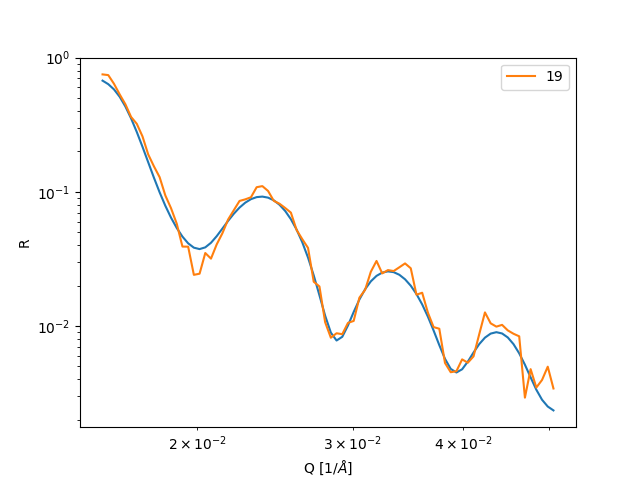

In [233]:

terminated = False
#while not terminated: 
for i in range(1):
    #time.sleep(1)

    # choose a random action
    #action = env.action_space.sample() 
    action = env.normalized_parameters

    # take the action and get the information from the environment
    new_state, reward, terminated, truncated, info = env.step(action)
    print("reward: %s" % reward)
    # show the current position and reward
    env.render(action=action, reward=reward) 
    env.plot()

In [234]:
from stable_baselines3 import PPO, SAC

model = SAC('MlpPolicy', env, verbose=0)

In [235]:
model.learn(100000)
model.save('cell-b-CV1-30')

In [140]:
model = SAC.load("cell-b-CV1-30")

In [236]:
# Evaluate the agent
episode_reward = 0

n_times = env.data.shape[0]
print("Number of times: %s" % n_times)

obs, info = env.reset()

actions = [env.normalized_parameters]
for i in range(n_times):
    action, _ = model.predict(obs, deterministic=True)
    actions.append(action)

    new_obs, reward, terminated, truncated, info = env.step(action)
    
    episode_reward += reward
    print("Time %s: %g [%s] %g" % (obs, reward, terminated, episode_reward))
    obs = new_obs

actions = np.asarray(actions)

Number of times: 29
Time [1.]: -1.33237 [False] -1.33237
Time [0.96428573]: -1.17183 [False] -2.5042
Time [0.9285714]: -1.02965 [False] -3.53385
Time [0.89285713]: -1.44297 [False] -4.97682
Time [0.85714287]: -1.53581 [False] -6.51262
Time [0.8214286]: -1.01206 [False] -7.52468
Time [0.78571427]: -1.10672 [False] -8.6314
Time [0.75]: -1.30682 [False] -9.93822
Time [0.71428573]: -1.23591 [False] -11.1741
Time [0.6785714]: -1.11314 [False] -12.2873
Time [0.64285713]: -1.46366 [False] -13.7509
Time [0.60714287]: -1.57473 [False] -15.3257
Time [0.5714286]: -1.29076 [False] -16.6164
Time [0.53571427]: -1.26941 [False] -17.8858
Time [0.5]: -1.43086 [False] -19.3167
Time [0.4642857]: -1.76926 [False] -21.0859
Time [0.42857143]: -2.89221 [False] -23.9781
Time [0.39285713]: -4.65839 [False] -28.6365
Time [0.35714287]: -5.60852 [False] -34.2451
Time [0.32142857]: -5.34961 [False] -39.5947
Time [0.2857143]: -5.92615 [False] -45.5208
Time [0.25]: -5.7309 [False] -51.2517
Time [0.21428572]: -5.4482

['THF interface', 'SEI thickness', 'SEI interface', 'SEI rho', 'SEI irho', 'material thickness', 'material interface', 'material rho', 'material irho']


<IPython.core.display.Javascript object>


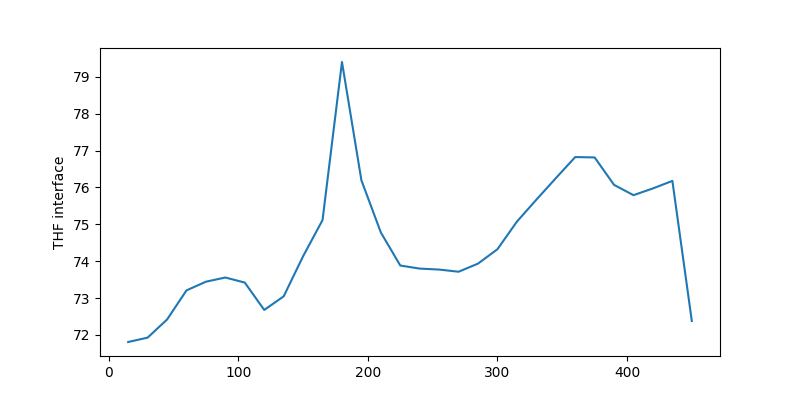

<IPython.core.display.Javascript object>


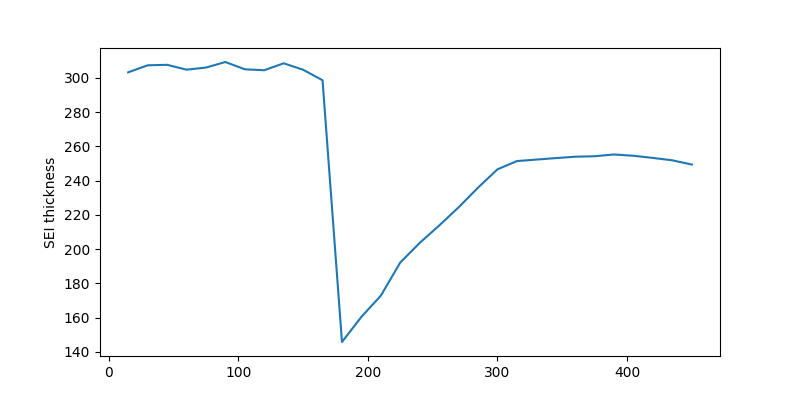

<IPython.core.display.Javascript object>


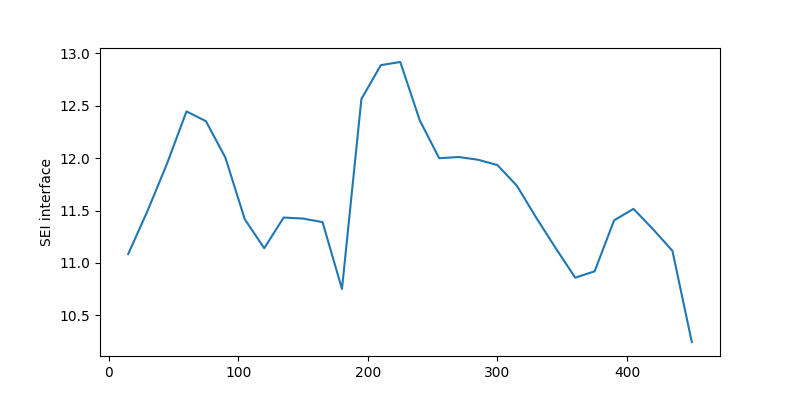

<IPython.core.display.Javascript object>


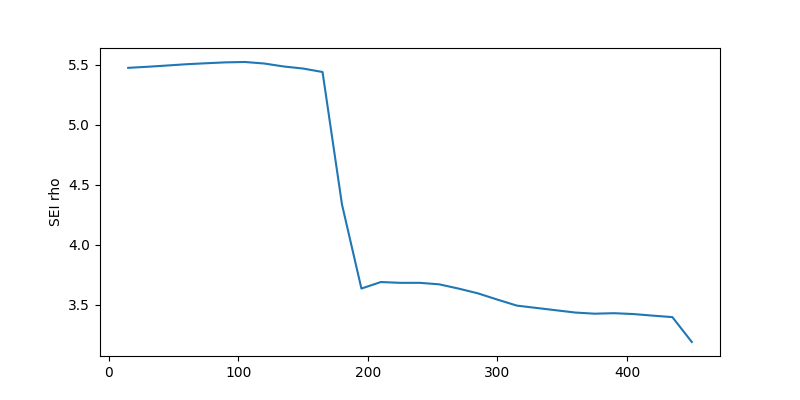

<IPython.core.display.Javascript object>


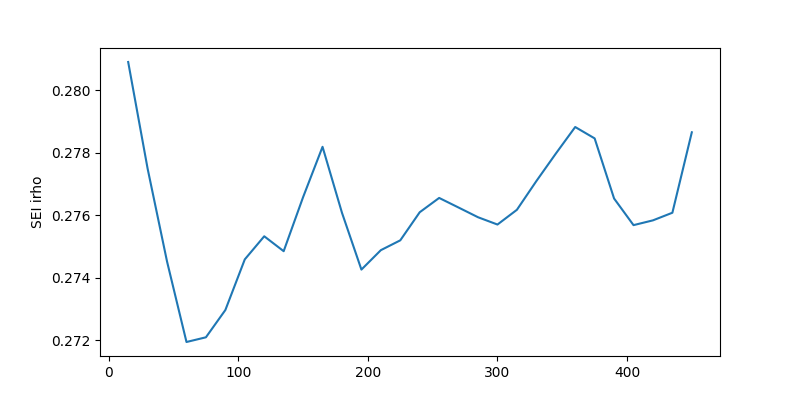

<IPython.core.display.Javascript object>


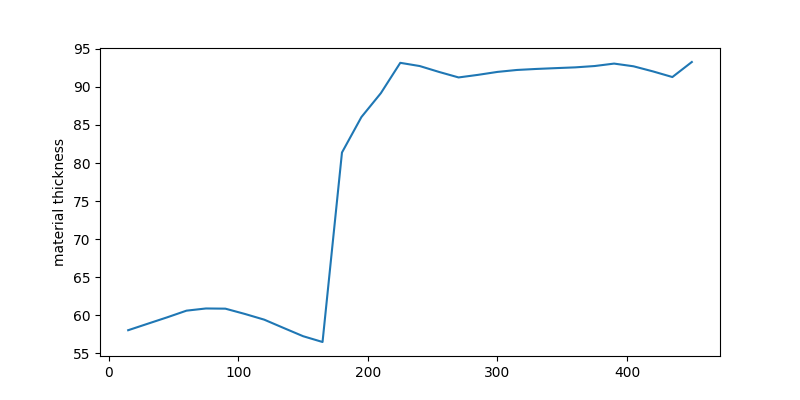

<IPython.core.display.Javascript object>


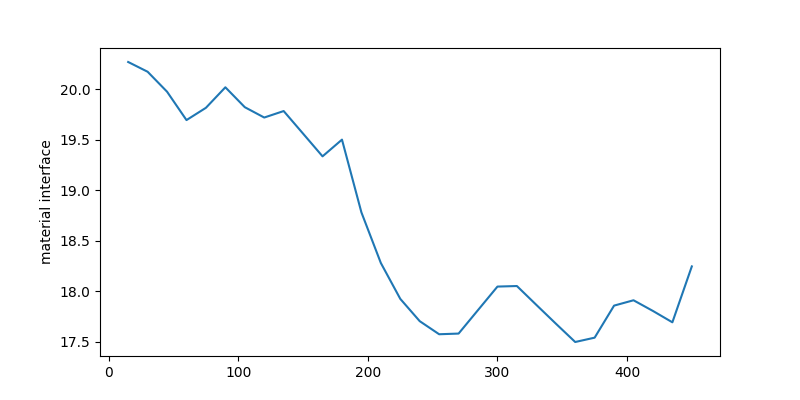

<IPython.core.display.Javascript object>


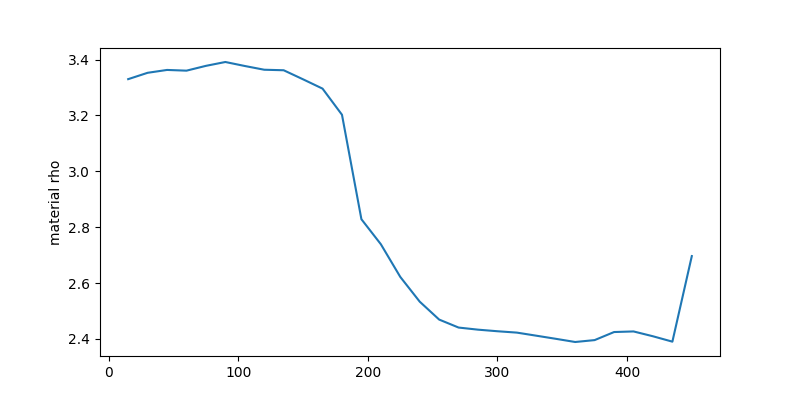

<IPython.core.display.Javascript object>


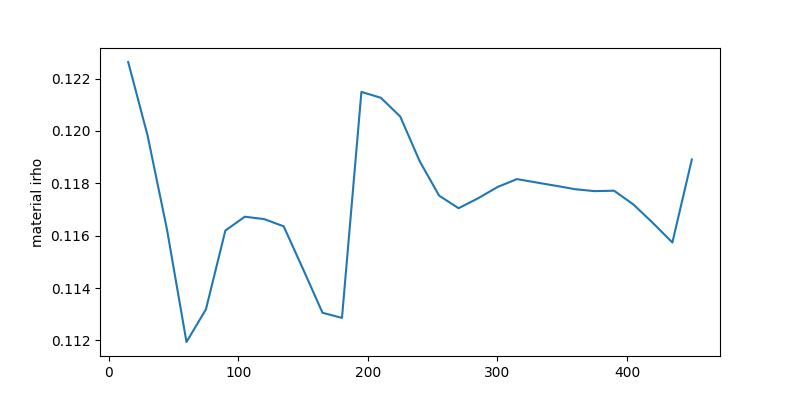

In [238]:
deltas = env.high_array - env.low_array
values = env.low_array + actions * deltas
    
pars = values.T

n_times = env.data.shape[0]

print(env.par_labels)
for i in range(pars.shape[0]):
    fig = plt.subplots(dpi=100, figsize=(8, 4))
    times = np.arange(n_times+1, 0, -1)*15.0
    plt.plot(times, pars[i], label=env.par_labels[i])
    plt.ylabel(env.par_labels[i])

Number of times: 29


<IPython.core.display.Javascript object>


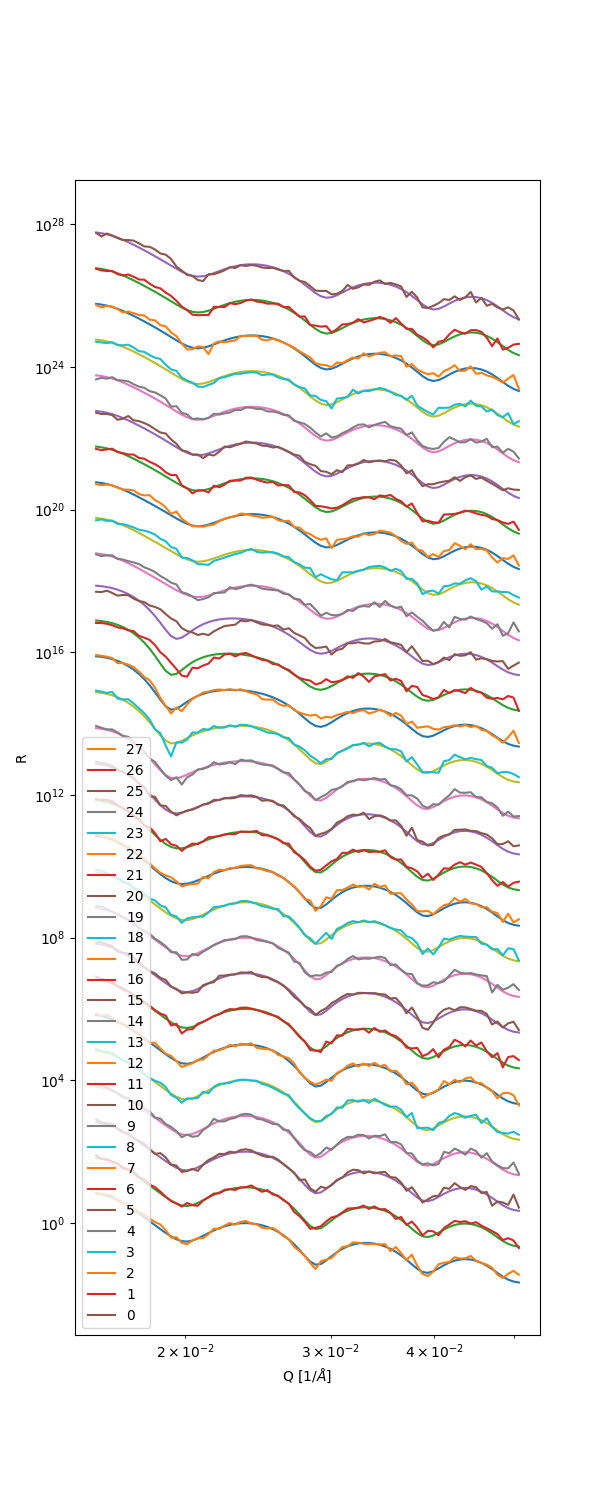

In [239]:
# Evaluate the agent
episode_reward = 0

n_times = env.data.shape[0]
print("Number of times: %s" % n_times)

obs, info = env.reset()

fig = plt.subplots(dpi=100, figsize=(6, 15))
for i in range(1, n_times, 1):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)

    env.plot(scale=10.**i, newfig=False)
